In [1]:
import re
import pandas as pd
import multiprocessing
from matplotlib import pyplot as plt
import matplotlib
import statistics
import os
import numpy as np

In [2]:
subs = """title = re.sub(re.escape('[O][O] + 2 [Pt] <=> 2 O=[Pt]'), 'R1', title)
    title = re.sub(re.escape('C + 2 [Pt] <=> C[Pt] + [Pt]'), 'R4', title)
    title = re.sub(re.escape('C + O=[Pt] + [Pt] <=> C[Pt] + O[Pt]'), 'R5', title)
    title = re.sub(re.escape('C + O[Pt] + [Pt] <=> C[Pt] + O.[Pt]'), 'R12', title)
    title = re.sub(re.escape('2 C=[Pt] <=> C[Pt] + C#[Pt]'), 'R32', title)
    title = re.sub(re.escape('C=[Pt] + O[Pt] <=> C[Pt] + O=[Pt]'), 'R30', title)
    title = re.sub(re.escape('[Pt] + O=[Pt] <=> O[Pt] + [Pt]'), 'R3', title)
    title = re.sub(re.escape('C=[Pt] + [Pt] <=> C[Pt] + [Pt]'), 'R6', title)
    title = re.sub(re.escape('C#[Pt] + [Pt] <=> C=[Pt] + [Pt]'), 'R7', title)
    title = re.sub(re.escape('C + [Pt] <=> C.[Pt]'), 'R19', title)
    title = re.sub(re.escape('C#[Pt] + O[Pt] <=> C=[Pt] + O=[Pt]'), 'R31', title)
    title = re.sub(re.escape('C=[Pt] + C~[Pt] <=> 2 C#[Pt]'), 'R35', title)
    title = re.sub(re.escape('C[Pt] + C~[Pt] <=> C=[Pt] + C#[Pt]'), 'R34', title)
    title = re.sub(re.escape('C~[Pt] + [H][H] <=> C=[Pt]'), 'R9', title)
    title = re.sub(re.escape('[H][H] + 2 [Pt] <=> 2 [Pt]'), 'R2', title)
    title = re.sub(re.escape('[H][H] + [Pt] <=> [H][H].[Pt]'), 'R20', title)
    title = re.sub(re.escape('O=C=O + [Pt] <=> O=C=O.[Pt]'), 'R16', title)
    title = re.sub(re.escape('O=C=O.[Pt] + [Pt] <=> O[Pt] + O=C=[Pt]'), 'R18', title)
    title = re.sub(re.escape('O=C=[Pt] + O=[Pt] <=> O=C=O.[Pt] + [Pt]'), 'R17', title)
    title = re.sub(re.escape('CO + 2 [Pt] <=> C[Pt] + O[Pt]'), 'R27', title)
    title = re.sub(re.escape('C=[Pt] + O=C[Pt] <=> C[Pt] + O=C=[Pt]'), 'R37', title)
    title = re.sub(re.escape('CC + 2 [Pt] <=> 2 C[Pt]'), 'R26', title)
    title = re.sub(re.escape('C~[Pt] + O=[Pt] <=> O=C=[Pt] + [Pt]'), 'R11', title)
    title = re.sub(re.escape('C~[Pt] + O[Pt] <=> C#[Pt] + O=[Pt]'), 'R33', title)
    title = re.sub(re.escape('O=C[Pt] + C~[Pt] <=> C#[Pt] + O=C=[Pt]'), 'R39', title)
    title = re.sub(re.escape('[OH] + [Pt] <=> O[Pt]'), 'R22', title)
    title = re.sub(re.escape('[H] + [Pt] <=> [Pt]'), 'R21', title)
    title = re.sub(re.escape('[CH3] + [Pt] <=> C[Pt]'), 'R23', title)
    title = re.sub(re.escape('O + [Pt] <=> O.[Pt]'), 'R13', title)
    title = re.sub(re.escape('O + 2 [Pt] <=> O[Pt] + [Pt]'), 'R25', title)
    title = re.sub(re.escape('O[Pt] + [Pt] <=> O.[Pt] + [Pt]'), 'R15', title)
    title = re.sub(re.escape('O.[Pt] + O=[Pt] <=> 2 O[Pt]'), 'R14', title)
    title = re.sub(re.escape('O=C[Pt] + O=[Pt] <=> O[Pt] + O=C=[Pt]'), 'R36', title)
    title = re.sub(re.escape('O=C[Pt] + C#[Pt] <=> C=[Pt] + O=C=[Pt]'), 'R38', title)
    title = re.sub(re.escape('O=C[Pt] + [Pt] <=> [Pt] + O=C=[Pt]'), 'R40', title)
    title = re.sub(re.escape('[CH]=O + [Pt] <=> O=C[Pt]'), 'R24', title)
    title = re.sub(re.escape('C=O + 2 [Pt] <=> O=C[Pt] + [Pt]'), 'R28', title)
    title = re.sub(re.escape('CC=O + 2 [Pt] <=> C[Pt] + O=C[Pt]'), 'R29', title)
    title = re.sub(re.escape('[C-]#[O+] + [Pt] <=> O=C=[Pt]'), 'R10', title)
    title = re.sub(re.escape('C#[Pt] + [Pt] <=> C~[Pt] + [Pt]'), 'R8', title)
    title = re.sub(re.escape('[C-]#[O+] + [Pt] <=> [C-]#[O+].[Pt]'), 'RX', title)"""
translation = {}
for l in subs.split("\n"):
    reaction, label = l.lstrip("""title = re.sub(re.escape('""").strip(""", title)""").split("'), ")
    label = label.strip("'").lstrip("'")
    translation[reaction] = label

In [3]:
ratios = [0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2, 1.3, 1.4, 1.6, 1.8, 2.0, 2.2, 2.4, 2.6]
ratios_title = ['06', '07', '08', '09', '10', '11', '12', '13', '14', '16', '18', '20', '22', '24', '26']
sens_types = ['SynGasSelec', 'SynGasYield', 'COSelec', 'COYield', 'H2Selec',
              'H2Yield', 'CH4Conv', 'FullOxSelec', 'FullOxYield', 'ExitT',
              'MaxT', 'DistToMaxT', 'O2Conv']


In [4]:
def import_sensitivities(ratio, file_location=False, thermo=False):
    """
    Ratio is the C/O starting gas ratio
    file_location is the LSR C and O binding energy, fasle to load the base case
    thermo is either False to load reaction sensitivities or True to load thermo sensitivities
    """
    if file_location is False:
        data = pd.read_csv('./rh/sensitivities/' + str(ratio) + 'RxnSensitivity.csv')
    else:
        data = pd.read_csv('./small-grid/' + file_location + '/sensitivities/' + str(ratio) + 'RxnSensitivity.csv')
    data = data.values
    data = data.tolist()
    return data


def loadSensDataWorker(array):
    # loading all ratio data
#     rxndata = []
#     for ratio in ratios:
#         rxndata.append(import_sensitivities(ratio, file_location=array))
    
    # just load C/O = 1.0
    rxndata = import_sensitivities(1.0, file_location=array)
    
    return rxndata

In [5]:
max_cpus = multiprocessing.cpu_count()

In [6]:
array = os.listdir('./small-grid/')
array = sorted(array)

In [7]:
lump = int(len(array)/max_cpus)
pool = multiprocessing.Pool(processes=max_cpus)
allrxndata = pool.map(loadSensDataWorker, array, lump)
pool.close()
pool.join()

allrxndata.append(import_sensitivities(1.0))  # appending rh data

# changed so it only works when one ratio is loaded in
reactions = set()  # create list of unique reactions
for f in range(len(allrxndata)):  # for each lsr binding energy
    for r in range(len(allrxndata[f])):  # for each reaction
        reactions.add(allrxndata[f][r][1])  # append th reaction itself (just one ratio)
reactions = list(reactions)

In [8]:
for rxn in reactions:
    try:
        translation[rxn]
    except:
        translation[rxn] = str(rxn)

In [9]:
c_s = []
o_s = []
for x in array:
    _, c, o = x.split("-")
    c = c[:-1]
    c = -1 *float(c)
    o = -1* float(o)
    c_s.append(c)
    o_s.append(o)

In [10]:
points = list(zip(c_s, o_s))
points.append('rh')
metal_index = list(range(82))

metal_index_dict = dict(zip(points, metal_index))
sens_index = list(range(len(sens_types)))
sens_index_dict = dict(zip(sens_types, sens_index))

In [11]:
# allrxndata[metal][reaction][sensitivities]
# sensitivities: 0 = index; 1 = reaction; 2, 3...15 = sensitivity index

def dataToPlot(metal, sens):
    sens = sens + 2
    tmp_data = []
    for rxn in range(len(allrxndata[metal_index[metal]])):
        tmp_data.append([translation[allrxndata[metal][rxn][1]], allrxndata[metal][rxn][sens]])
    key = next(key for key, value in metal_index_dict.items() if value == metal)
    return [key, sorted(tmp_data, key=lambda x: abs(x[1]))]


def dataToPlotWorker(metal):
    return dataToPlot(metal, sens_index_dict['CH4Conv'])  # load for methane conversion


In [12]:
def reorderDataToPlot(data):
    # setting reactions in order as they show up in rh
    sorted_data = []
    for x in data:
        if x[0] is 'rh':
            # keep the first metal data in the sorted order
            sorted_data.append([x[0], x[1]])
        else:
            tmp_dict = dict(x[1])
            tmp_list = []

            for rxn in bottom_right[0][1]:
                r = rxn[0]
                try:
                    tmp_list.append([r, tmp_dict[r]])
                except:
                    # this reaction did not show up
                    tmp_list.append([r, 0.])
            sorted_data.append([x[0], tmp_list])
    return sorted_data


In [26]:
def plotSensComparison(location, title, cutoff=False, sort=False):
    num_plots = len(location)
    fig, axs = plt.subplots(1, num_plots, figsize=(30,15))
    # setting the x axes to be the same across all subplots
    MAX = 0
    for m in range(len(location)):
        width = [row[1] for row in location[m][1]]
        if max(map(abs, width)) > MAX:
            MAX = max(map(abs, width))
    
    for m in range(len(location)):
        axs[m].set_title(location[m][0], fontsize=22)
        
        if cutoff is not False:
            cutoff = int(cutoff)
            width_less = width[-1*cutoff:]
            ticks_less = ticks[-1*cutoff:]
            y_less = y[-1*cutoff:]
            if sort is not False:
                if m == 0:
                    axs[m].barh(y_less, width_less, tick_label=ticks_less)
                else:
                    axs[m].barh(y_less, width_less)
                    axs[m].get_yaxis().set_ticks([])
            else:
                axs[m].barh(y_less, width_less, tick_label=ticks_less)
            
        else:
            width = [row[1] for row in location[m][1]]
            ticks = [row[0] for row in location[m][1]]
            y = list(range(len(location[m][1])))
            if sort is not False:
                if m == 0:
                    axs[m].barh(y, width, tick_label=ticks)
                else:
                    axs[m].barh(y, width)
                    axs[m].get_yaxis().set_ticks([])
            else:
                axs[m].barh(y, width, tick_label=ticks)
            
        for item in (axs[m].get_yticklabels()):
                 item.set_fontsize(18)
        for item in (axs[m].get_xticklabels()):
                 item.set_fontsize(18)
        axs[m].set_xlim(-1*MAX, MAX)

    axs[1].set_xlabel('volcano peak', fontsize=18)
    
    plt.savefig('./sens-small-figures/' + str(title) + '.pdf',bbox_inches='tight',dpi=300)
    

In [27]:
def loadDataToPlot(metal_list):
    tmp_index = []
    for metal in metal_list:
        tmp_index.append(metal_index_dict[metal])
    return tmp_index


In [28]:
load_bottom_right = ['rh', (-6.75, -5.0), (-6.5, -5.0), (-6.25, -4.75), (-6.0, -4.5), (-5.75, -4.25)]
load_bottom_left = ['rh', (-6.75, -5.0), (-7.0, -5.0), (-7.25, -5.0), (-7.5, -4.75)]
# load_top = ['rh', (-6.75, -5.0), (-4.0, -7.5), (-4.0, -7.25), (-4.0, -7.0), (-4.0, -6.75), (-4.0, -6.5)]
load_top_local_max = ['rh', (-6.75, -5.0), (-6.25, -3.75), (-6.25, -3.5), (-6.25, -3.25), (-6.0, -3.25), (-6.0, -3.5)]
load_peak = ['rh', (-6.75, -5.0), (-7.0, -5.0), (-6.5, -5.0)]

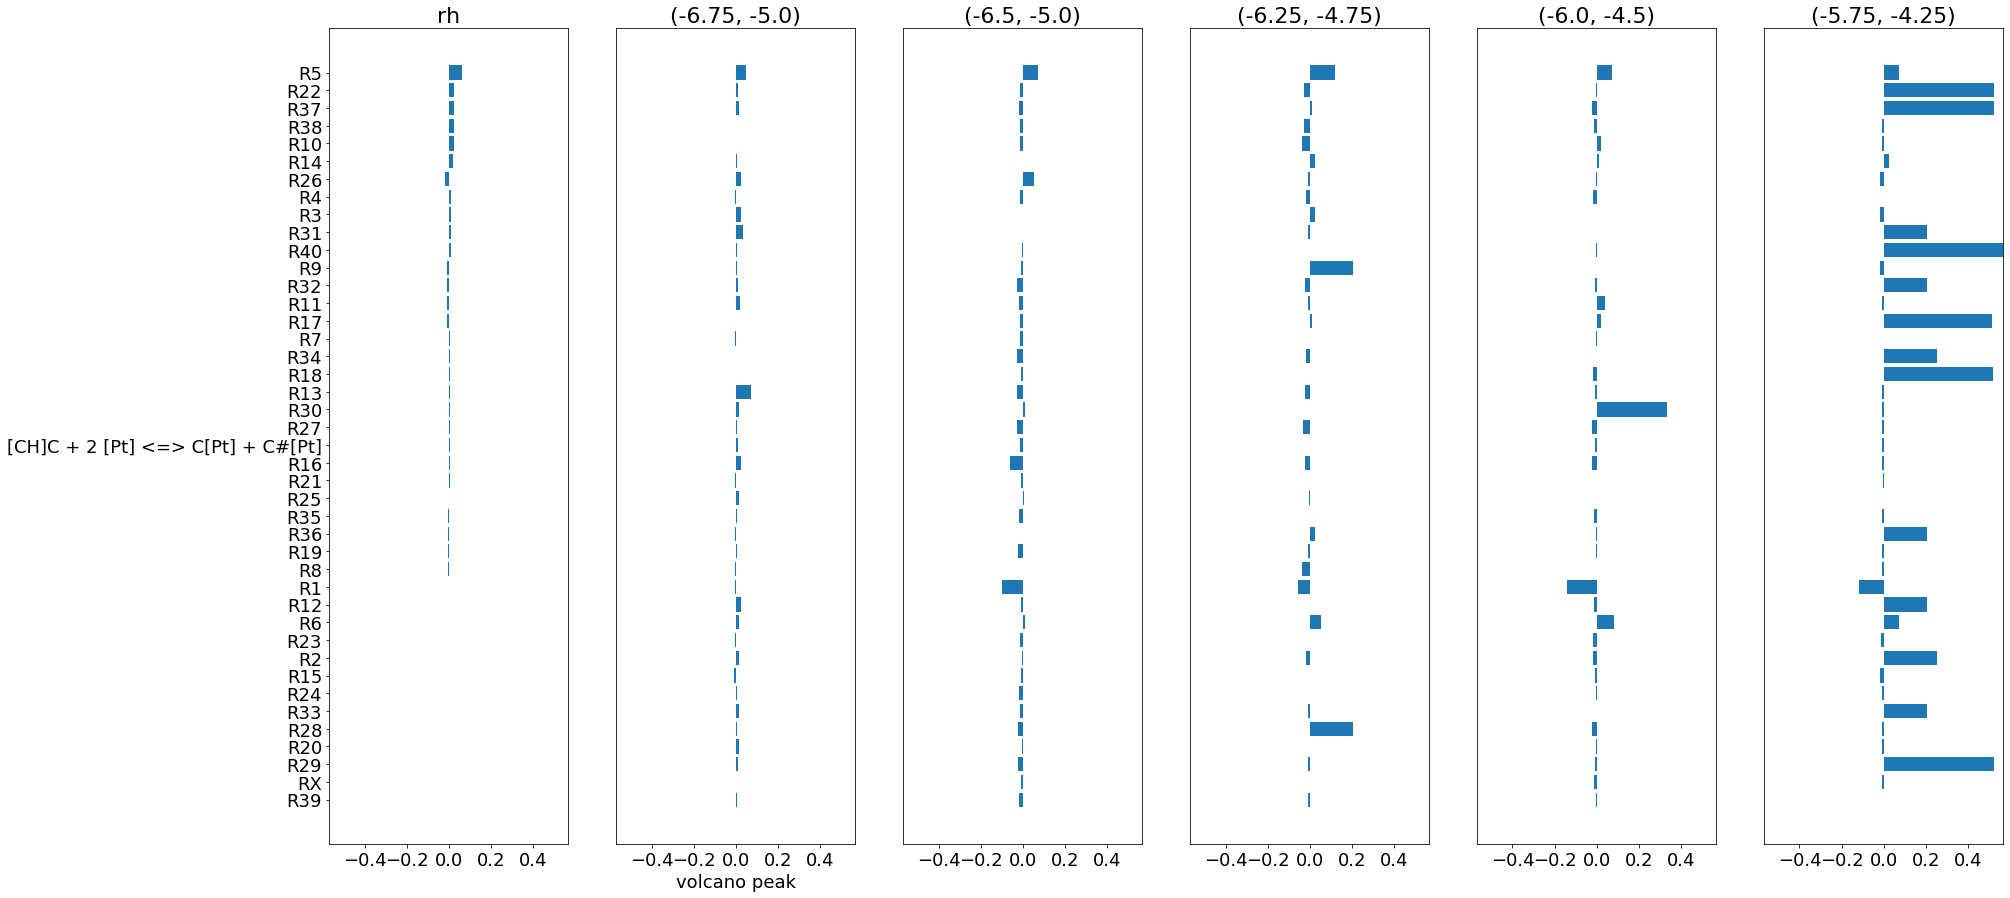

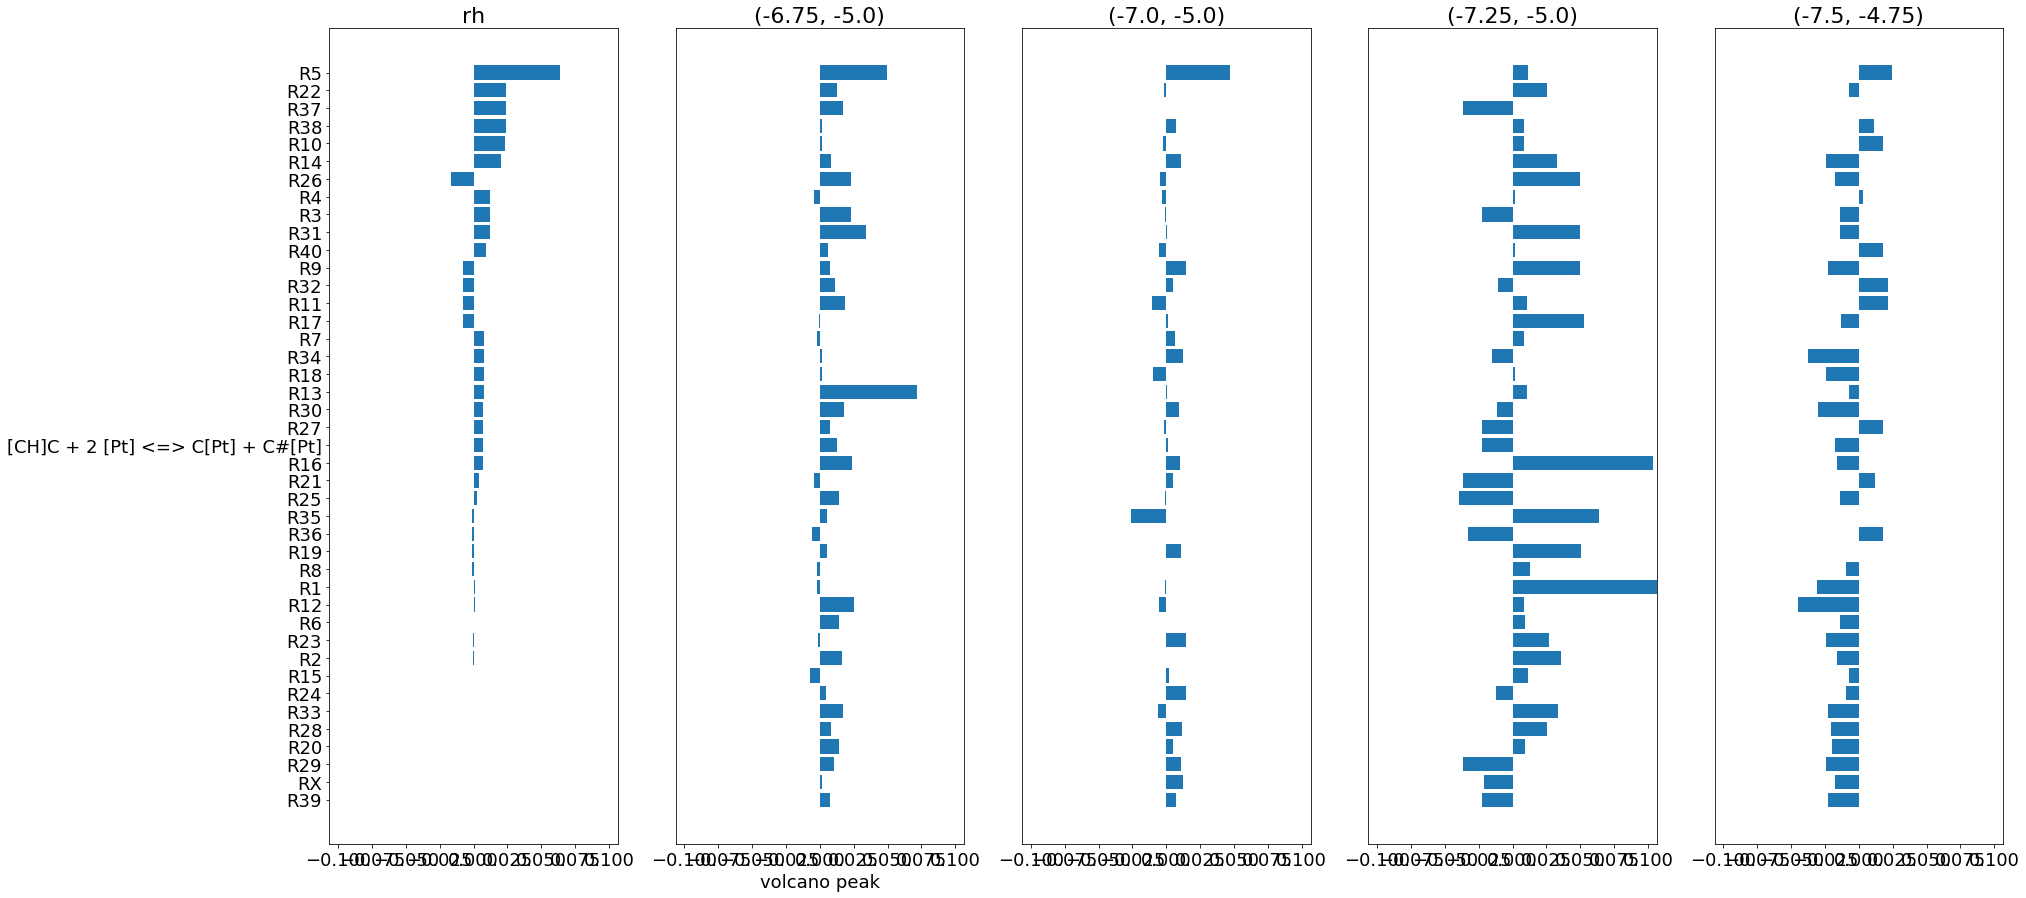

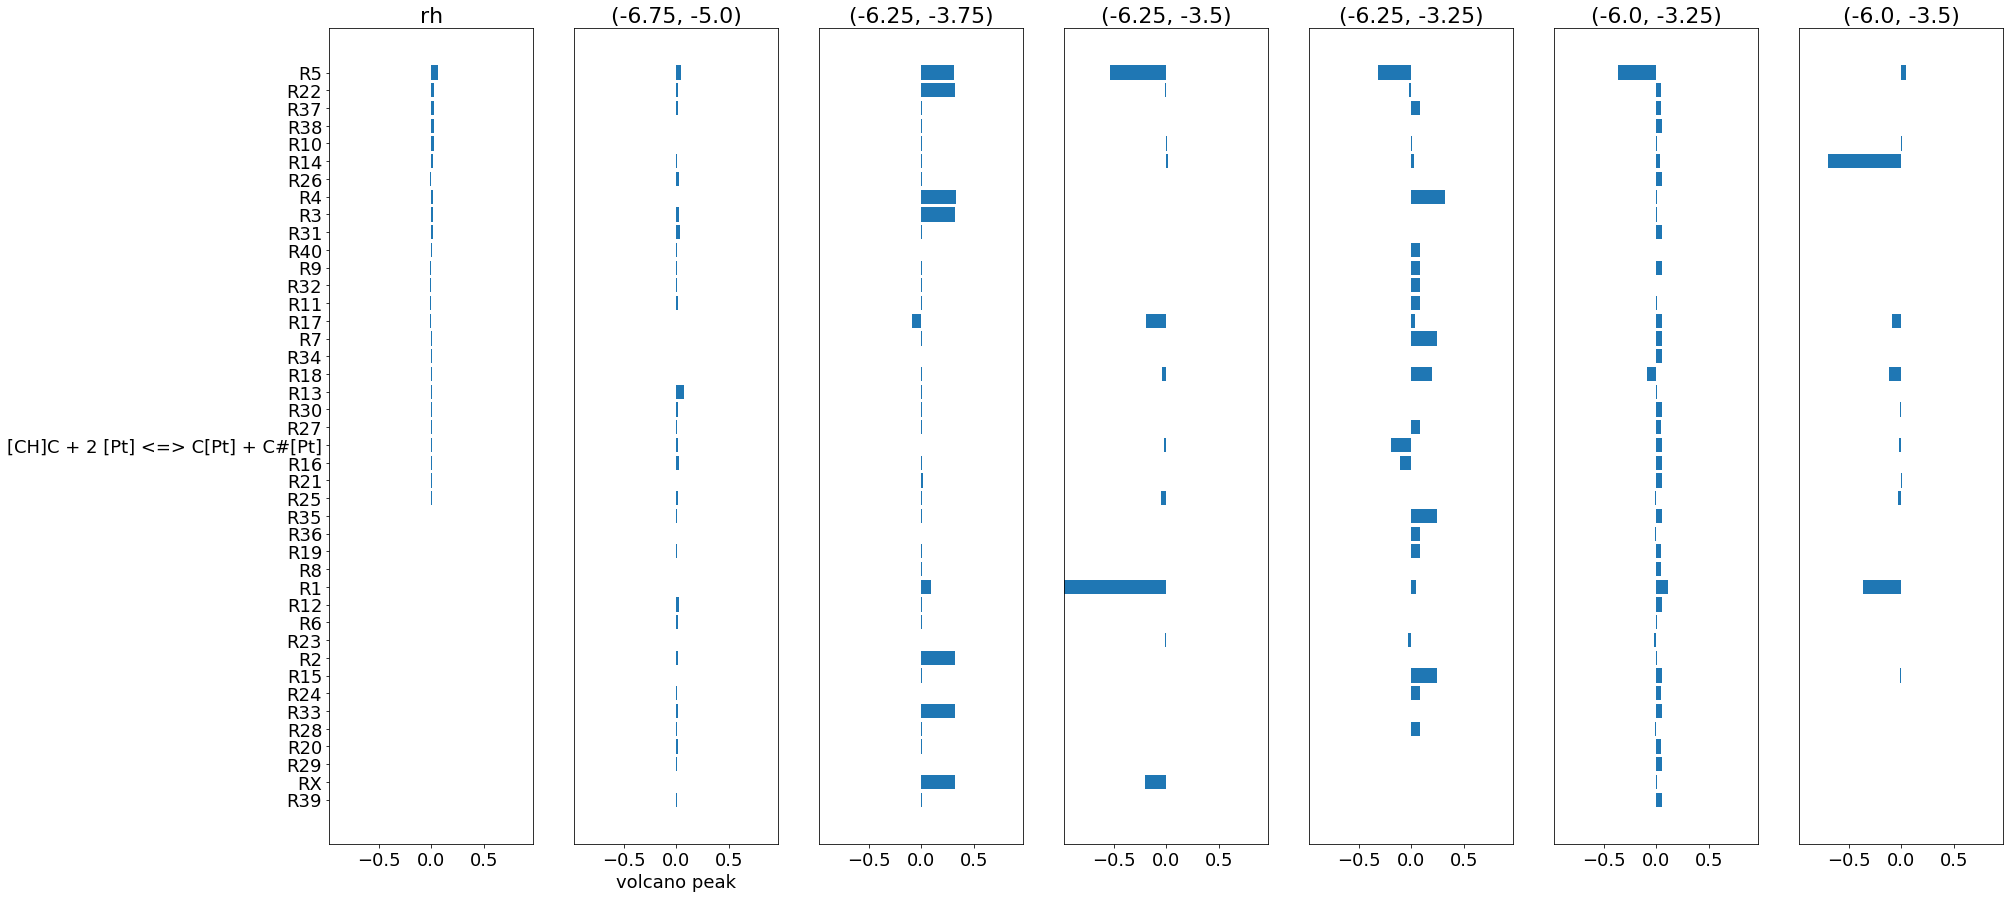

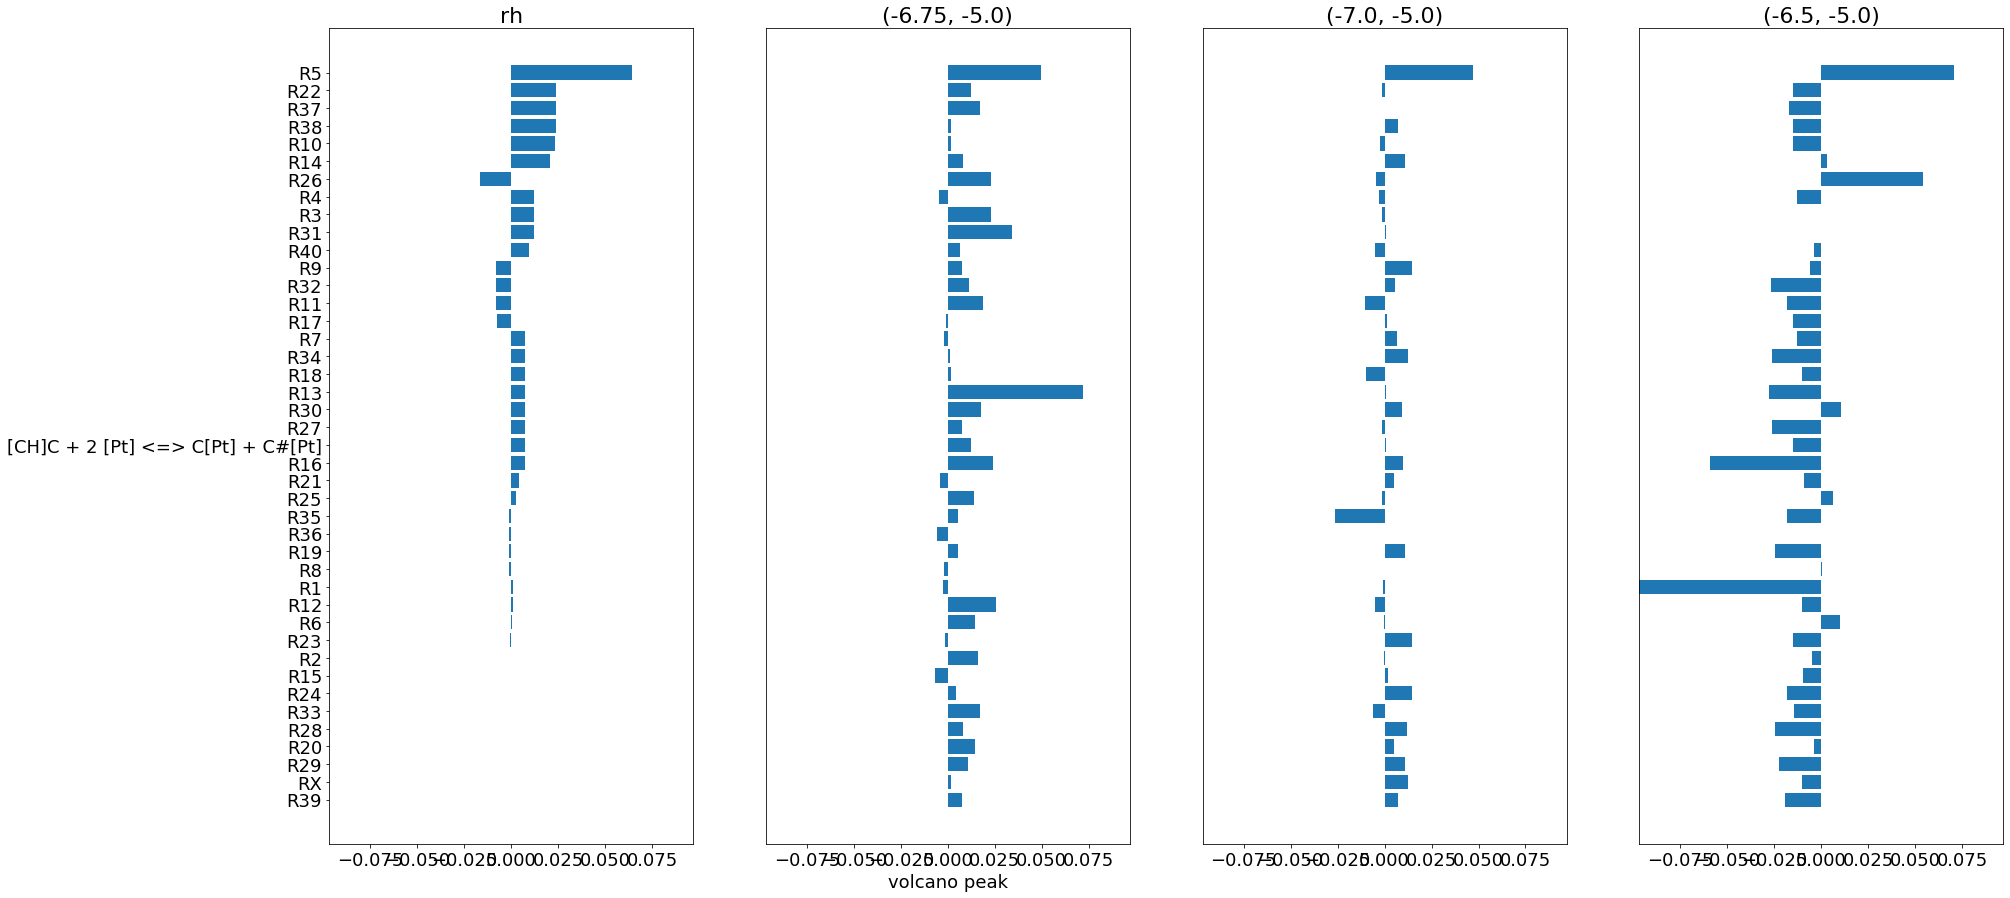

In [29]:
interesting_spots = [load_bottom_right, load_bottom_left, load_top_local_max, load_peak]

titles = ['bottomrightsorted', 'bottomleftsorted', 'toplocalmaxsorted', 'peaksorted']
interesting_spots_loaded = []
for x in range(len(interesting_spots)):
    x_data = loadDataToPlot(interesting_spots[x])
    tmp_data = []
    for metal in x_data:
        tmp_data.append(dataToPlot(metal, sens_index_dict['CH4Conv']))
    plot_data = reorderDataToPlot(tmp_data)
    title = titles[x]
    plotSensComparison(plot_data, title, sort=True)


# for x in interesting_spots_loaded:
#     for y in x:
#         dataToPlot(y, sens_index_dict['CH4Conv'])


# num_threads = len(load_bottom_right)
# pool = multiprocessing.Pool(processes=num_threads)
# bottom_right = pool.map(dataToPlotWorker, loadDataToPlot(load_bottom_right), 1)
# pool.close()
# pool.join()

# num_threads = len(load_bottom_left)
# pool = multiprocessing.Pool(processes=num_threads)
# bottom_left = pool.map_async(dataToPlotWorker, loadDataToPlot(load_bottom_left), 1)
# pool.close()
# pool.join()

# num_threads = len(load_top_local_max)
# pool = multiprocessing.Pool(processes=num_threads)
# top_local_max = pool.map_async(dataToPlotWorker, loadDataToPlot(load_top_local_max), 1)
# pool.close()
# pool.join()

# num_threads = len(load_peak)
# pool = multiprocessing.Pool(processes=num_threads)
# peak = pool.map_async(dataToPlotWorker, loadDataToPlot(load_peak), 1)
# pool.close()
# pool.join()

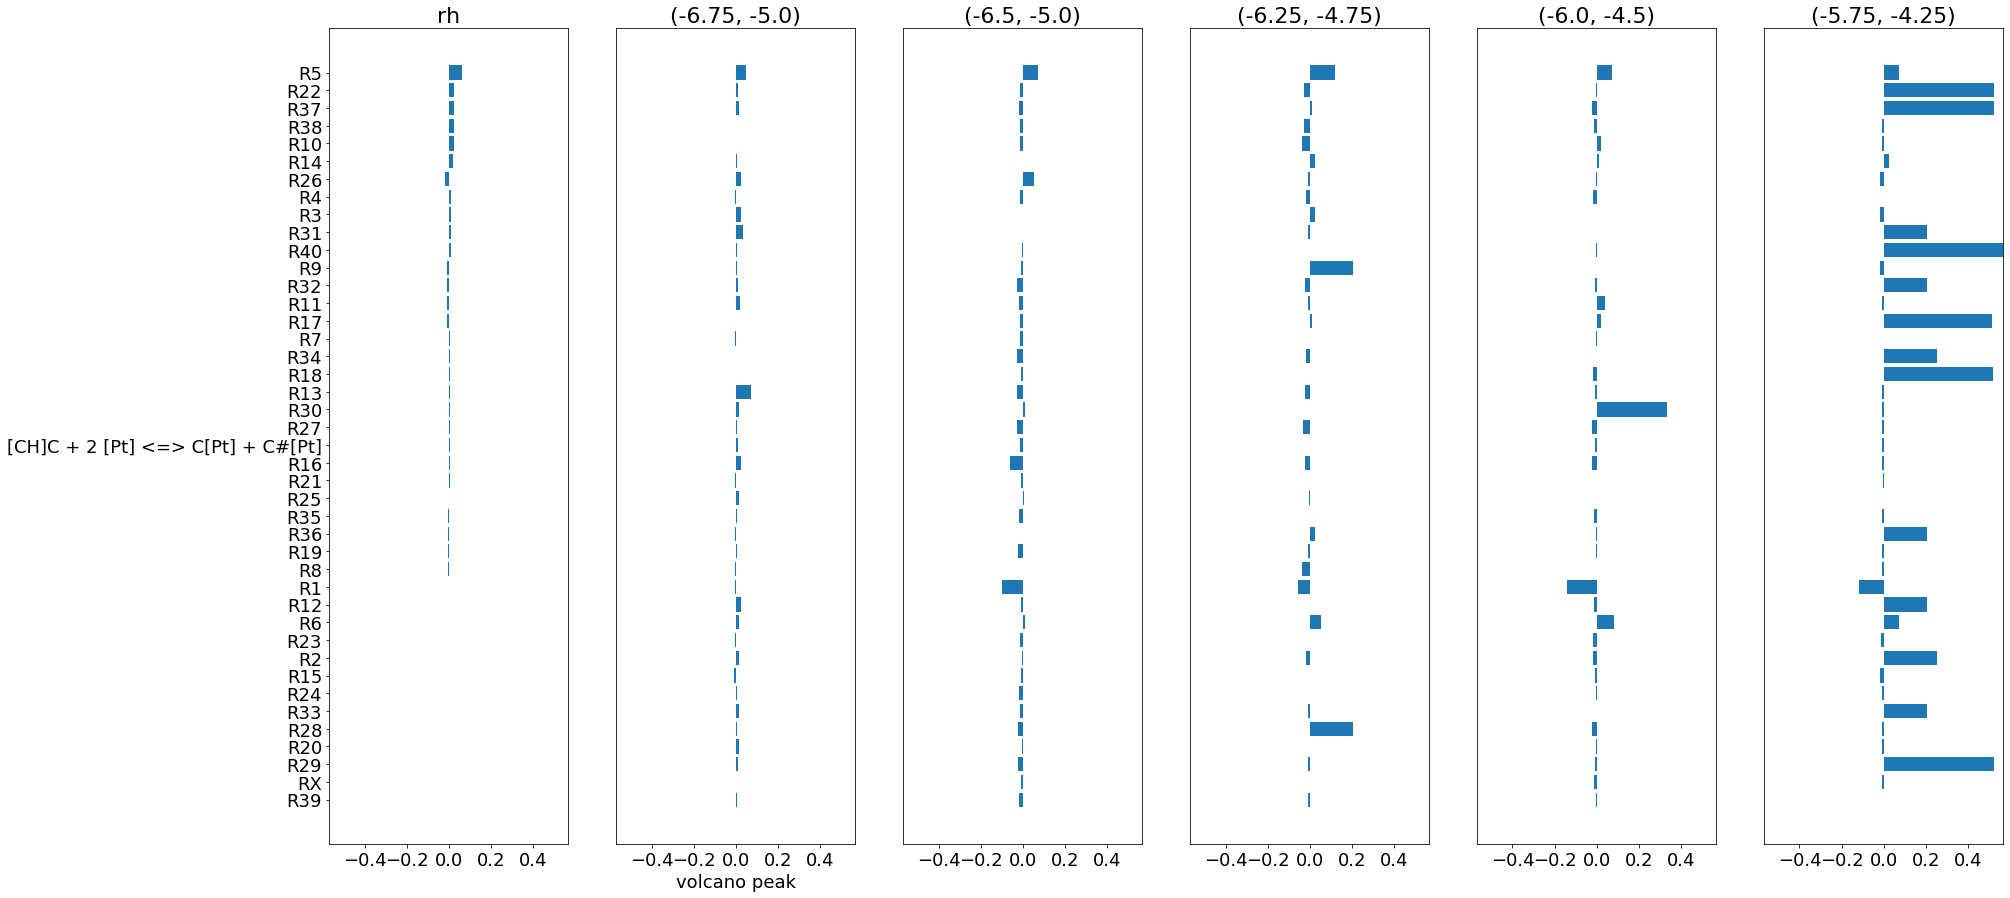

In [22]:
loaded_bottom_right = loadDataToPlot(load_bottom_right)
bottom_right = []
for metal in loaded_bottom_right:
    bottom_right.append(dataToPlot(metal, sens_index_dict['CH4Conv']))
bottom_right_sorted = reorderDataToPlot(bottom_right)
plotSensComparison(bottom_right_sorted, 'bottomrightsorted', sort=True)

In [ ]:
bottom_right_sorted = reorderDataToPlot(bottom_right)
bottom_left_sorted = reorderDataToPlot(bottom_left)
top_local_max_sorted = reorderDataToPlot(top_local_max)
peak_sorted = reorderDataToPlot(peak)

plotSensComparison(bottom_right_sorted, 'bottomrightsorted', sort=True)